# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor
import os
import tests
from torchvision import transforms

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transformz = [
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

    return Compose(transformz)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.image_paths = sorted(glob(os.path.join(directory, '*' + extension)))
   

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

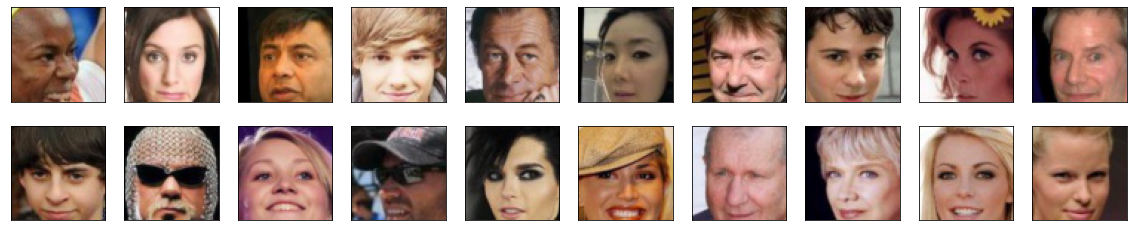

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
import torch.nn as nn
from torch.nn import Module

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 64x64x3
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32x32x64
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16x128
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8x256
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4x4x512
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        # Architecture of the generator
        self.model = nn.Sequential(
            # Input: [batch_size, latent_dim, 1, 1]
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # 4x4x512
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 8x8x256
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 16x16x128
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 32x32x64
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, x):
        # Forward pass through the generator
        return self.model(x)

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.1, 0.5))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.1, 0.1))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    loss = torch.mean(fake_logits)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    real_loss = torch.mean(real_logits)
    fake_loss = torch.mean(fake_logits)
    loss = real_loss - fake_loss
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    batch_size = real_samples.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1)
    interpolated_samples = epsilon * real_samples + (1 - epsilon) * fake_samples
    interpolated_samples.requires_grad_(True)
    interpolated_logits = discriminator(interpolated_samples)
    gradients = torch.autograd.grad(outputs=interpolated_logits, inputs=interpolated_samples,
                                    grad_outputs=torch.ones_like(interpolated_logits),
                                    create_graph=True, retain_graph=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=(1, 2, 3)) - 1) ** 2).mean()
    return gradient_penalty

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(generator, discriminator, g_optimizer, batch_size, latent_dim):
    latent_vectors = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(latent_vectors)
    fake_logits = discriminator(fake_images)
    g_loss = generator_loss(fake_logits)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    return {'loss': g_loss.item()}

def discriminator_step(generator, discriminator, d_optimizer, batch_size, latent_dim, real_images):
    latent_vectors = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(latent_vectors)
    real_logits = discriminator(real_images)
    fake_logits = discriminator(fake_images.detach())
    d_loss = discriminator_loss(real_logits, fake_logits)
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    return {'loss': d_loss.item()}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [20]:
latent_dim = 128
n_epochs = 15
batch_size = 64
g_lr = 0.0001
d_lr = 0.0001
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-09-05 17:22:06 | Epoch [1/15] | Batch 0/509 | d_loss: 0.1223 | g_loss: 1.0430
2023-09-05 17:22:13 | Epoch [1/15] | Batch 50/509 | d_loss: -50.0367 | g_loss: 23.1785
2023-09-05 17:22:19 | Epoch [1/15] | Batch 100/509 | d_loss: -99.2786 | g_loss: 47.2221
2023-09-05 17:22:26 | Epoch [1/15] | Batch 150/509 | d_loss: -141.8867 | g_loss: 69.8460
2023-09-05 17:22:31 | Epoch [1/15] | Batch 200/509 | d_loss: -158.8368 | g_loss: 93.3547
2023-09-05 17:22:37 | Epoch [1/15] | Batch 250/509 | d_loss: -190.0679 | g_loss: 81.0153
2023-09-05 17:22:44 | Epoch [1/15] | Batch 300/509 | d_loss: -244.7849 | g_loss: 136.3050
2023-09-05 17:22:50 | Epoch [1/15] | Batch 350/509 | d_loss: -283.4675 | g_loss: 157.9203
2023-09-05 17:22:56 | Epoch [1/15] | Batch 400/509 | d_loss: -316.5007 | g_loss: 166.6755
2023-09-05 17:23:02 | Epoch [1/15] | Batch 450/509 | d_loss: -292.5370 | g_loss: 122.1778
2023-09-05 17:23:09 | Epoch [1/15] | Batch 500/509 | d_loss: -431.0403 | g_loss: 222.4233


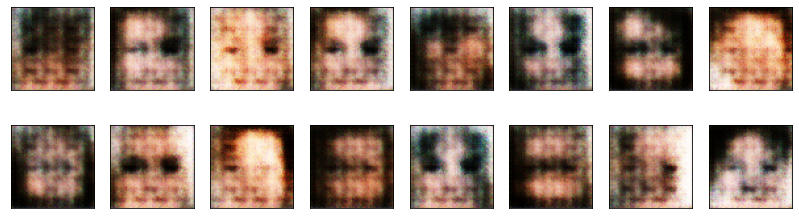

2023-09-05 17:23:14 | Epoch [2/15] | Batch 0/509 | d_loss: -371.9903 | g_loss: 121.3551
2023-09-05 17:23:20 | Epoch [2/15] | Batch 50/509 | d_loss: -467.7917 | g_loss: 246.1148
2023-09-05 17:23:26 | Epoch [2/15] | Batch 100/509 | d_loss: -485.0164 | g_loss: 227.0151
2023-09-05 17:23:32 | Epoch [2/15] | Batch 150/509 | d_loss: -527.4178 | g_loss: 291.1338
2023-09-05 17:23:38 | Epoch [2/15] | Batch 200/509 | d_loss: -663.9894 | g_loss: 337.9905
2023-09-05 17:23:44 | Epoch [2/15] | Batch 250/509 | d_loss: -613.4805 | g_loss: 340.0931
2023-09-05 17:23:50 | Epoch [2/15] | Batch 300/509 | d_loss: -625.8836 | g_loss: 291.4635
2023-09-05 17:23:56 | Epoch [2/15] | Batch 350/509 | d_loss: -784.5495 | g_loss: 388.8052
2023-09-05 17:24:03 | Epoch [2/15] | Batch 400/509 | d_loss: -853.6993 | g_loss: 428.7923
2023-09-05 17:24:09 | Epoch [2/15] | Batch 450/509 | d_loss: -767.9683 | g_loss: 206.3108
2023-09-05 17:24:15 | Epoch [2/15] | Batch 500/509 | d_loss: -995.7974 | g_loss: 508.5243


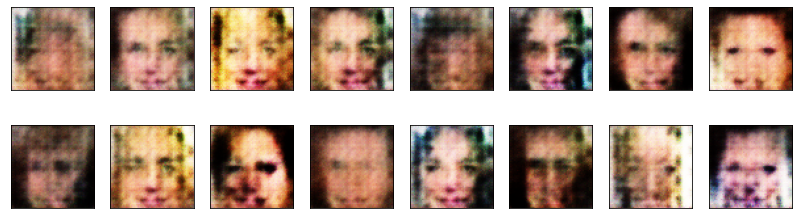

2023-09-05 17:24:20 | Epoch [3/15] | Batch 0/509 | d_loss: -565.0295 | g_loss: 494.4588
2023-09-05 17:24:26 | Epoch [3/15] | Batch 50/509 | d_loss: -695.0076 | g_loss: 405.6774
2023-09-05 17:24:32 | Epoch [3/15] | Batch 100/509 | d_loss: -456.2628 | g_loss: 497.8492
2023-09-05 17:24:39 | Epoch [3/15] | Batch 150/509 | d_loss: -861.7126 | g_loss: 596.6516
2023-09-05 17:24:46 | Epoch [3/15] | Batch 200/509 | d_loss: -1206.5200 | g_loss: 618.6726
2023-09-05 17:24:52 | Epoch [3/15] | Batch 250/509 | d_loss: -1066.1605 | g_loss: 553.9224
2023-09-05 17:24:58 | Epoch [3/15] | Batch 300/509 | d_loss: -1339.6002 | g_loss: 678.8123
2023-09-05 17:25:04 | Epoch [3/15] | Batch 350/509 | d_loss: -1009.1104 | g_loss: 704.3309
2023-09-05 17:25:11 | Epoch [3/15] | Batch 400/509 | d_loss: -849.9030 | g_loss: 716.2345
2023-09-05 17:25:17 | Epoch [3/15] | Batch 450/509 | d_loss: -1501.5872 | g_loss: 765.4390
2023-09-05 17:25:24 | Epoch [3/15] | Batch 500/509 | d_loss: -1631.3040 | g_loss: 815.3256


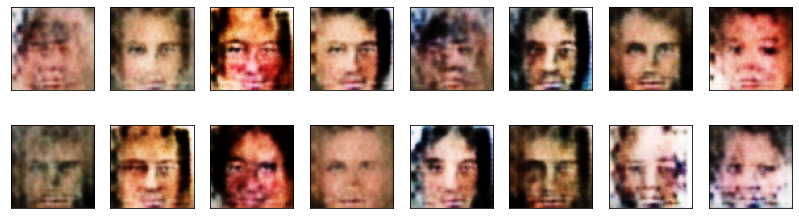

2023-09-05 17:25:29 | Epoch [4/15] | Batch 0/509 | d_loss: -1491.5824 | g_loss: 826.0639
2023-09-05 17:25:35 | Epoch [4/15] | Batch 50/509 | d_loss: -1672.2913 | g_loss: 855.1120
2023-09-05 17:25:41 | Epoch [4/15] | Batch 100/509 | d_loss: -1756.1133 | g_loss: 880.0997
2023-09-05 17:25:47 | Epoch [4/15] | Batch 150/509 | d_loss: -1782.7422 | g_loss: 905.2566
2023-09-05 17:25:53 | Epoch [4/15] | Batch 200/509 | d_loss: -1685.4916 | g_loss: 907.7523
2023-09-05 17:25:59 | Epoch [4/15] | Batch 250/509 | d_loss: -1378.2445 | g_loss: 13.0407
2023-09-05 17:26:05 | Epoch [4/15] | Batch 300/509 | d_loss: -1992.5215 | g_loss: 987.5732
2023-09-05 17:26:12 | Epoch [4/15] | Batch 350/509 | d_loss: -1619.5588 | g_loss: 910.2092
2023-09-05 17:26:18 | Epoch [4/15] | Batch 400/509 | d_loss: -2175.9438 | g_loss: 1078.3435
2023-09-05 17:26:24 | Epoch [4/15] | Batch 450/509 | d_loss: -1928.9958 | g_loss: 709.8799
2023-09-05 17:26:30 | Epoch [4/15] | Batch 500/509 | d_loss: -2248.8384 | g_loss: 1110.4523


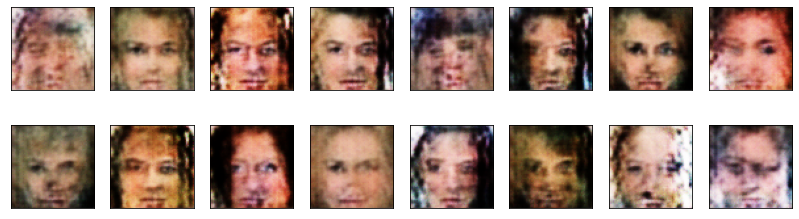

2023-09-05 17:26:35 | Epoch [5/15] | Batch 0/509 | d_loss: -2219.7256 | g_loss: 1163.6094
2023-09-05 17:26:41 | Epoch [5/15] | Batch 50/509 | d_loss: -2359.8088 | g_loss: 1216.2373
2023-09-05 17:26:47 | Epoch [5/15] | Batch 100/509 | d_loss: -2374.7871 | g_loss: 1207.1277
2023-09-05 17:26:53 | Epoch [5/15] | Batch 150/509 | d_loss: -2044.6920 | g_loss: 703.7098
2023-09-05 17:26:59 | Epoch [5/15] | Batch 200/509 | d_loss: -2366.0708 | g_loss: 1134.2728
2023-09-05 17:27:07 | Epoch [5/15] | Batch 250/509 | d_loss: -2183.8125 | g_loss: 931.4407
2023-09-05 17:27:13 | Epoch [5/15] | Batch 300/509 | d_loss: -2149.2637 | g_loss: 980.5109
2023-09-05 17:27:19 | Epoch [5/15] | Batch 350/509 | d_loss: -2609.0767 | g_loss: 1389.3499
2023-09-05 17:27:25 | Epoch [5/15] | Batch 400/509 | d_loss: -2466.0688 | g_loss: 907.1805
2023-09-05 17:27:31 | Epoch [5/15] | Batch 450/509 | d_loss: -767.6942 | g_loss: 1156.8147
2023-09-05 17:27:37 | Epoch [5/15] | Batch 500/509 | d_loss: -2862.8926 | g_loss: 1383.0

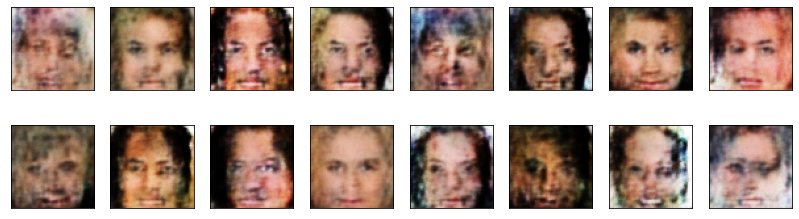

2023-09-05 17:27:43 | Epoch [6/15] | Batch 0/509 | d_loss: -2433.9258 | g_loss: 1479.3042
2023-09-05 17:27:49 | Epoch [6/15] | Batch 50/509 | d_loss: -3002.6113 | g_loss: 1497.7284
2023-09-05 17:27:55 | Epoch [6/15] | Batch 100/509 | d_loss: -2931.2500 | g_loss: 1268.6821
2023-09-05 17:28:01 | Epoch [6/15] | Batch 150/509 | d_loss: -3097.1216 | g_loss: 1373.1741
2023-09-05 17:28:07 | Epoch [6/15] | Batch 200/509 | d_loss: -2900.5923 | g_loss: 1532.0487
2023-09-05 17:28:14 | Epoch [6/15] | Batch 250/509 | d_loss: -3093.8091 | g_loss: 1731.9474
2023-09-05 17:28:20 | Epoch [6/15] | Batch 300/509 | d_loss: -3135.2344 | g_loss: 1548.8015
2023-09-05 17:28:27 | Epoch [6/15] | Batch 350/509 | d_loss: -2831.1475 | g_loss: 899.9974
2023-09-05 17:28:33 | Epoch [6/15] | Batch 400/509 | d_loss: -2962.7373 | g_loss: 1698.4321
2023-09-05 17:28:39 | Epoch [6/15] | Batch 450/509 | d_loss: -3282.0762 | g_loss: 1732.2539
2023-09-05 17:28:45 | Epoch [6/15] | Batch 500/509 | d_loss: -2816.5679 | g_loss: -2

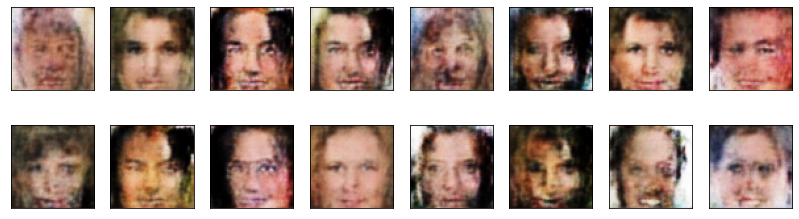

2023-09-05 17:28:49 | Epoch [7/15] | Batch 0/509 | d_loss: -3815.2148 | g_loss: 1890.6660
2023-09-05 17:28:55 | Epoch [7/15] | Batch 50/509 | d_loss: -3759.7866 | g_loss: 1839.9990
2023-09-05 17:29:01 | Epoch [7/15] | Batch 100/509 | d_loss: -3446.8354 | g_loss: 1595.7233
2023-09-05 17:29:07 | Epoch [7/15] | Batch 150/509 | d_loss: -3858.8542 | g_loss: 2073.4363
2023-09-05 17:29:14 | Epoch [7/15] | Batch 200/509 | d_loss: -4089.7839 | g_loss: 2010.0679
2023-09-05 17:29:20 | Epoch [7/15] | Batch 250/509 | d_loss: -4272.1387 | g_loss: 2143.0723
2023-09-05 17:29:27 | Epoch [7/15] | Batch 300/509 | d_loss: -4067.9312 | g_loss: 1867.1823
2023-09-05 17:29:33 | Epoch [7/15] | Batch 350/509 | d_loss: -4182.7935 | g_loss: 2237.0913
2023-09-05 17:29:39 | Epoch [7/15] | Batch 400/509 | d_loss: -4601.3823 | g_loss: 2305.5647
2023-09-05 17:29:45 | Epoch [7/15] | Batch 450/509 | d_loss: -3300.7273 | g_loss: 2260.5332
2023-09-05 17:29:51 | Epoch [7/15] | Batch 500/509 | d_loss: -1671.4524 | g_loss: 2

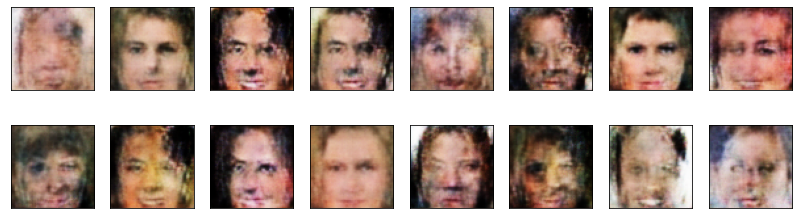

2023-09-05 17:29:56 | Epoch [8/15] | Batch 0/509 | d_loss: -916.8979 | g_loss: 2218.4971
2023-09-05 17:30:02 | Epoch [8/15] | Batch 50/509 | d_loss: -4835.5840 | g_loss: 2358.2732
2023-09-05 17:30:09 | Epoch [8/15] | Batch 100/509 | d_loss: -5003.8086 | g_loss: 2503.3838
2023-09-05 17:30:15 | Epoch [8/15] | Batch 150/509 | d_loss: -4208.4624 | g_loss: 2357.8674
2023-09-05 17:30:21 | Epoch [8/15] | Batch 200/509 | d_loss: -5151.9990 | g_loss: 2587.0210
2023-09-05 17:30:27 | Epoch [8/15] | Batch 250/509 | d_loss: -5228.8564 | g_loss: 2592.5186
2023-09-05 17:30:34 | Epoch [8/15] | Batch 300/509 | d_loss: -4066.5498 | g_loss: 2563.0801
2023-09-05 17:30:41 | Epoch [8/15] | Batch 350/509 | d_loss: -5430.8643 | g_loss: 2664.2686
2023-09-05 17:30:47 | Epoch [8/15] | Batch 400/509 | d_loss: -5452.7686 | g_loss: 2676.9795
2023-09-05 17:30:53 | Epoch [8/15] | Batch 450/509 | d_loss: -5643.4849 | g_loss: 2747.5483
2023-09-05 17:30:59 | Epoch [8/15] | Batch 500/509 | d_loss: -5730.3076 | g_loss: 28

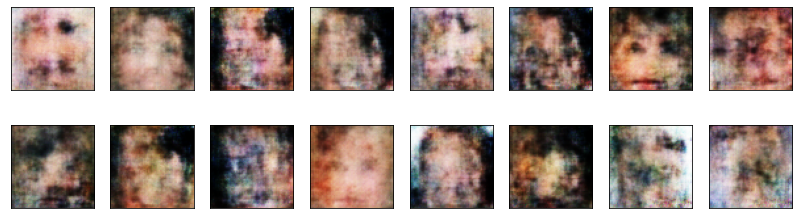

2023-09-05 17:31:04 | Epoch [9/15] | Batch 0/509 | d_loss: -5747.3838 | g_loss: 2827.6396
2023-09-05 17:31:11 | Epoch [9/15] | Batch 50/509 | d_loss: -5952.1846 | g_loss: 2885.6045
2023-09-05 17:31:17 | Epoch [9/15] | Batch 100/509 | d_loss: -5878.6577 | g_loss: 2936.1897
2023-09-05 17:31:24 | Epoch [9/15] | Batch 150/509 | d_loss: -5116.7124 | g_loss: 2966.1060
2023-09-05 17:31:30 | Epoch [9/15] | Batch 200/509 | d_loss: -6131.7710 | g_loss: 3019.3032
2023-09-05 17:31:36 | Epoch [9/15] | Batch 250/509 | d_loss: -6344.7598 | g_loss: 3096.3525
2023-09-05 17:31:42 | Epoch [9/15] | Batch 300/509 | d_loss: -6392.8301 | g_loss: 3123.4253
2023-09-05 17:31:48 | Epoch [9/15] | Batch 350/509 | d_loss: -6527.2324 | g_loss: 3174.9023
2023-09-05 17:31:54 | Epoch [9/15] | Batch 400/509 | d_loss: -6469.1982 | g_loss: 3209.2827
2023-09-05 17:32:00 | Epoch [9/15] | Batch 450/509 | d_loss: -6509.0229 | g_loss: 3237.7471
2023-09-05 17:32:06 | Epoch [9/15] | Batch 500/509 | d_loss: -6780.2090 | g_loss: 3

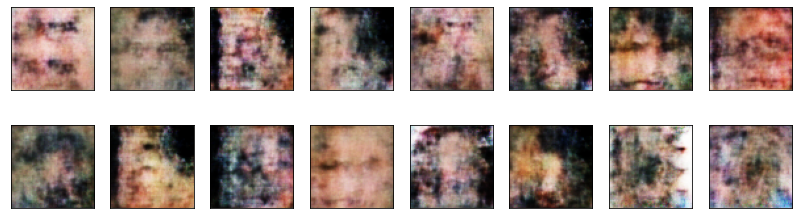

2023-09-05 17:32:12 | Epoch [10/15] | Batch 0/509 | d_loss: -6879.4570 | g_loss: 3345.4263
2023-09-05 17:32:18 | Epoch [10/15] | Batch 50/509 | d_loss: -7020.4131 | g_loss: 3405.9170
2023-09-05 17:32:24 | Epoch [10/15] | Batch 100/509 | d_loss: -7095.9678 | g_loss: 3451.3315
2023-09-05 17:32:30 | Epoch [10/15] | Batch 150/509 | d_loss: -7231.6543 | g_loss: 3506.5415
2023-09-05 17:32:36 | Epoch [10/15] | Batch 200/509 | d_loss: -7276.1689 | g_loss: 3554.9995
2023-09-05 17:32:42 | Epoch [10/15] | Batch 250/509 | d_loss: -7411.5078 | g_loss: 3612.3977
2023-09-05 17:32:48 | Epoch [10/15] | Batch 300/509 | d_loss: -7509.1411 | g_loss: 3667.9922
2023-09-05 17:32:54 | Epoch [10/15] | Batch 350/509 | d_loss: -7693.4888 | g_loss: 3748.2166
2023-09-05 17:33:00 | Epoch [10/15] | Batch 400/509 | d_loss: -7661.7070 | g_loss: 3773.7822
2023-09-05 17:33:07 | Epoch [10/15] | Batch 450/509 | d_loss: -7762.5288 | g_loss: 3824.0183
2023-09-05 17:33:13 | Epoch [10/15] | Batch 500/509 | d_loss: -7975.4409 

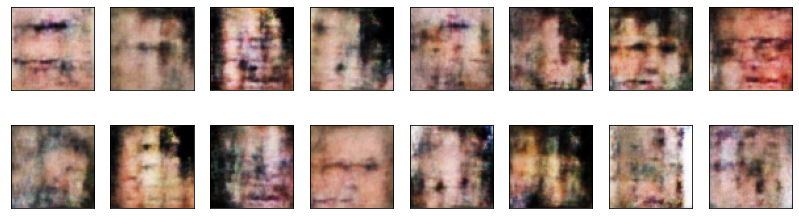

2023-09-05 17:33:18 | Epoch [11/15] | Batch 0/509 | d_loss: -7829.8862 | g_loss: 3870.5532
2023-09-05 17:33:24 | Epoch [11/15] | Batch 50/509 | d_loss: -8105.5615 | g_loss: 3924.4116
2023-09-05 17:33:30 | Epoch [11/15] | Batch 100/509 | d_loss: -8268.0977 | g_loss: 4024.5286
2023-09-05 17:33:37 | Epoch [11/15] | Batch 150/509 | d_loss: -8173.9297 | g_loss: 4069.6616
2023-09-05 17:33:44 | Epoch [11/15] | Batch 200/509 | d_loss: -8503.6660 | g_loss: 4127.2051
2023-09-05 17:33:50 | Epoch [11/15] | Batch 250/509 | d_loss: -8555.6992 | g_loss: 4157.0059
2023-09-05 17:33:56 | Epoch [11/15] | Batch 300/509 | d_loss: -8704.7383 | g_loss: 4216.9780
2023-09-05 17:34:02 | Epoch [11/15] | Batch 350/509 | d_loss: -8836.0879 | g_loss: 4271.0498
2023-09-05 17:34:08 | Epoch [11/15] | Batch 400/509 | d_loss: -8911.0713 | g_loss: 4321.8203
2023-09-05 17:34:15 | Epoch [11/15] | Batch 450/509 | d_loss: -8998.0195 | g_loss: 4400.9365
2023-09-05 17:34:21 | Epoch [11/15] | Batch 500/509 | d_loss: -9151.5117 

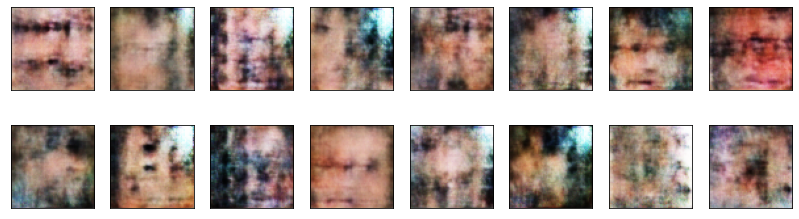

2023-09-05 17:34:25 | Epoch [12/15] | Batch 0/509 | d_loss: -9182.6602 | g_loss: 4467.7729
2023-09-05 17:34:31 | Epoch [12/15] | Batch 50/509 | d_loss: -9346.3301 | g_loss: 4519.4990
2023-09-05 17:34:37 | Epoch [12/15] | Batch 100/509 | d_loss: -9455.7637 | g_loss: 4584.8315
2023-09-05 17:34:43 | Epoch [12/15] | Batch 150/509 | d_loss: -9547.7500 | g_loss: 4608.6221
2023-09-05 17:34:50 | Epoch [12/15] | Batch 200/509 | d_loss: -9671.9971 | g_loss: 4702.3125
2023-09-05 17:34:56 | Epoch [12/15] | Batch 250/509 | d_loss: -9770.5684 | g_loss: 4729.9702
2023-09-05 17:35:02 | Epoch [12/15] | Batch 300/509 | d_loss: -9841.6289 | g_loss: 4810.5210
2023-09-05 17:35:08 | Epoch [12/15] | Batch 350/509 | d_loss: -10018.3555 | g_loss: 4858.6025
2023-09-05 17:35:15 | Epoch [12/15] | Batch 400/509 | d_loss: -10145.2646 | g_loss: 4926.6523
2023-09-05 17:35:21 | Epoch [12/15] | Batch 450/509 | d_loss: -9795.8730 | g_loss: 4990.7866
2023-09-05 17:35:27 | Epoch [12/15] | Batch 500/509 | d_loss: -10398.01

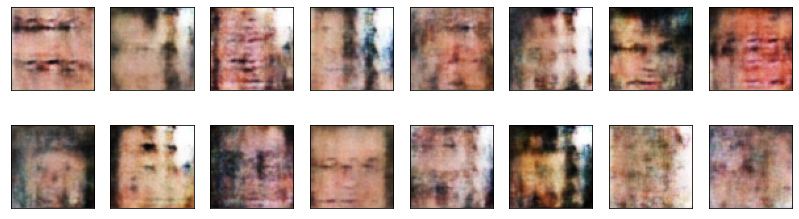

2023-09-05 17:35:32 | Epoch [13/15] | Batch 0/509 | d_loss: -10431.4863 | g_loss: 5051.1348
2023-09-05 17:35:38 | Epoch [13/15] | Batch 50/509 | d_loss: -10626.3486 | g_loss: 5150.5625
2023-09-05 17:35:44 | Epoch [13/15] | Batch 100/509 | d_loss: -10676.4629 | g_loss: 5180.5601
2023-09-05 17:35:50 | Epoch [13/15] | Batch 150/509 | d_loss: -10819.6357 | g_loss: 5222.0479
2023-09-05 17:35:56 | Epoch [13/15] | Batch 200/509 | d_loss: -10911.7930 | g_loss: 5278.4033
2023-09-05 17:36:03 | Epoch [13/15] | Batch 250/509 | d_loss: -11058.1328 | g_loss: 5341.6719
2023-09-05 17:36:09 | Epoch [13/15] | Batch 300/509 | d_loss: -11192.2793 | g_loss: 5423.5083
2023-09-05 17:36:16 | Epoch [13/15] | Batch 350/509 | d_loss: -11330.3164 | g_loss: 5485.6416
2023-09-05 17:36:22 | Epoch [13/15] | Batch 400/509 | d_loss: -11439.7344 | g_loss: 5569.0366
2023-09-05 17:36:28 | Epoch [13/15] | Batch 450/509 | d_loss: -11566.0518 | g_loss: 5589.3965
2023-09-05 17:36:34 | Epoch [13/15] | Batch 500/509 | d_loss: -

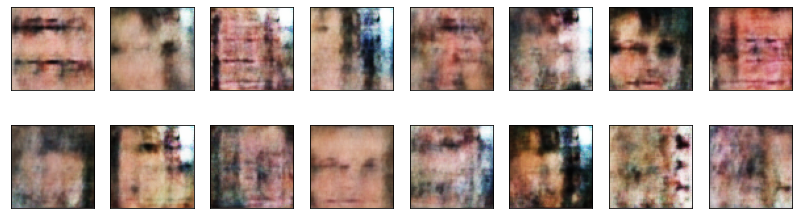

2023-09-05 17:36:39 | Epoch [14/15] | Batch 0/509 | d_loss: -11693.6055 | g_loss: 5665.8281
2023-09-05 17:36:45 | Epoch [14/15] | Batch 50/509 | d_loss: -11781.0352 | g_loss: 5740.5786
2023-09-05 17:36:51 | Epoch [14/15] | Batch 100/509 | d_loss: -11978.5703 | g_loss: 5775.3110
2023-09-05 17:36:57 | Epoch [14/15] | Batch 150/509 | d_loss: -11950.6152 | g_loss: 5818.4844
2023-09-05 17:37:03 | Epoch [14/15] | Batch 200/509 | d_loss: -12193.0723 | g_loss: 5895.5015
2023-09-05 17:37:10 | Epoch [14/15] | Batch 250/509 | d_loss: -12297.0791 | g_loss: 5966.1479
2023-09-05 17:37:16 | Epoch [14/15] | Batch 300/509 | d_loss: -12477.3887 | g_loss: 6033.2402
2023-09-05 17:37:23 | Epoch [14/15] | Batch 350/509 | d_loss: -12570.8867 | g_loss: 6044.2529
2023-09-05 17:37:29 | Epoch [14/15] | Batch 400/509 | d_loss: -12749.0605 | g_loss: 6138.6846
2023-09-05 17:37:35 | Epoch [14/15] | Batch 450/509 | d_loss: -12871.5127 | g_loss: 6199.7144
2023-09-05 17:37:41 | Epoch [14/15] | Batch 500/509 | d_loss: -

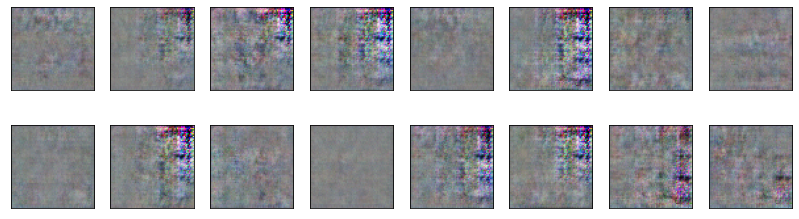

2023-09-05 17:37:46 | Epoch [15/15] | Batch 0/509 | d_loss: -13069.1895 | g_loss: 6290.1924
2023-09-05 17:37:52 | Epoch [15/15] | Batch 50/509 | d_loss: -13206.7168 | g_loss: 6370.3638
2023-09-05 17:37:58 | Epoch [15/15] | Batch 100/509 | d_loss: -13348.2695 | g_loss: 6440.3149
2023-09-05 17:38:04 | Epoch [15/15] | Batch 150/509 | d_loss: -13502.5684 | g_loss: 6504.8188
2023-09-05 17:38:11 | Epoch [15/15] | Batch 200/509 | d_loss: -13630.0273 | g_loss: 6565.0605
2023-09-05 17:38:18 | Epoch [15/15] | Batch 250/509 | d_loss: -13761.4414 | g_loss: 6628.7969
2023-09-05 17:38:24 | Epoch [15/15] | Batch 300/509 | d_loss: -13884.8604 | g_loss: 6690.1514
2023-09-05 17:38:30 | Epoch [15/15] | Batch 350/509 | d_loss: -14049.6543 | g_loss: 6767.1484
2023-09-05 17:38:36 | Epoch [15/15] | Batch 400/509 | d_loss: -14186.5527 | g_loss: 6834.1538
2023-09-05 17:38:42 | Epoch [15/15] | Batch 450/509 | d_loss: -14314.8320 | g_loss: 6902.0308
2023-09-05 17:38:48 | Epoch [15/15] | Batch 500/509 | d_loss: -

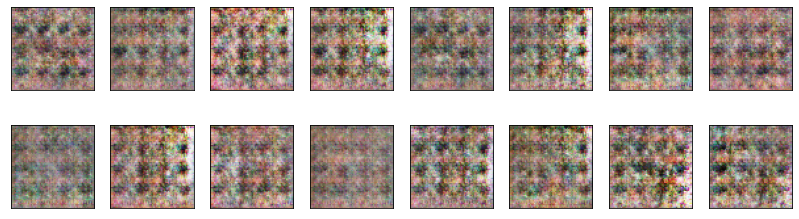

In [23]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)  # Precompute and move to device

generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        # Train the discriminator
        d_loss = discriminator_step(generator, discriminator, d_optimizer, batch_size, latent_dim, real_images)
        
        # Clip gradients for the discriminator optimizer
        for param in discriminator.parameters():
            param.grad.data.clamp_(-0.01, 0.01)
        
        g_loss = generator_step(generator, discriminator, g_optimizer, batch_size, latent_dim)
        
        discriminator_losses.append(d_loss['loss'])
        generator_losses.append(g_loss['loss'])
        
        if batch_i % print_every == 0:
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d_loss["loss"]:.4f} | g_loss: {g_loss["loss"]:.4f}')
   
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

    # Decrease learning rates after each batch
    g_optimizer.param_groups[0]['lr'] *= 0.99
    d_optimizer.param_groups[0]['lr'] *= 0.99

### Training losses

Plot the training losses for the generator and discriminator.

In [24]:
losses = np.array([discriminator_losses, generator_losses])

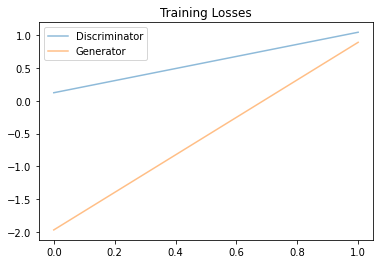

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** 

The generated samples mostly resemble white "celebrity" faces due to dataset bias. 

To improve:

Diverse Data: Include more diverse facial data for balanced representation.

Larger Model: Use bigger models for finer details.

Optimization: Tweak optimizer settings, learning rates, and epochs.

Loss Functions: Experiment with different loss functions for better results.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.